In [1]:
import torch
import torch.nn as nn
import numpy as np
import pyro
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import pyro.distributions as dist

c:\Users\flose\anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cpu")

In [3]:
class PyroLinear(pyro.nn.PyroModule):
    def __init__(self, in_features, out_features, prior_var):
        super().__init__()
        self.linear = pyro.nn.PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = pyro.nn.PyroSample(dist.Normal(0.0, prior_var).expand((out_features, in_features)).to_event(2))
        self.linear.bias = pyro.nn.PyroSample(dist.Normal(0.0, prior_var).expand((out_features,)).to_event(1))

    def forward(self, x):
        return self.linear(x)

In [28]:
class PyroVIModule(pyro.nn.PyroModule):
    def __init__(self, layers, noise=None):
        super().__init__()
        self.model = layers
        self.noise = noise
        self.losses = []

    def _model(self, x, y=None):
        if self.noise is None:
            noise = pyro.sample("noise", dist.Uniform(0.0, 10.0))
        else:
            noise = self.noise
        mean = self.model(x)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, noise).to_event(1), obs=y)
        return mean

    def train_model(self, epochs, loader, batch_size, device, report_every_epochs=1):
        self.model.to(device)
        self.model.train()

        self.guide = pyro.infer.autoguide.AutoMultivariateNormal(self._model)
        optimizer = pyro.optim.Adam({"lr": 0.001})
        svi = pyro.infer.SVI(self._model, self.guide, optimizer, loss=pyro.infer.Trace_ELBO())
        pyro.clear_param_store()

        for epoch in range(epochs):
            epoch_loss = torch.tensor(0, dtype=torch.float)
            for data, target in loader:
                loss = svi.step(data, target)
                epoch_loss += loss
            epoch_loss /= (len(loader) * batch_size)
            self.losses.append(epoch_loss.detach())
            if report_every_epochs > 0 and epoch % report_every_epochs == 0:
                print(f"Epoch {epoch}: loss {epoch_loss}")
        if report_every_epochs >= 0:
            print(f"Final loss {epoch_loss}")
    
    def all_losses(self):
        return [self.losses]

    def infer(self, input, samples):
        predictive = pyro.infer.Predictive(self._model, guide=self.guide, num_samples=samples)
        output = predictive(input)["obs"]
        return torch.stack((output, self.noise.expand(output.shape)), -1)

In [29]:
from experiments.toy_regression import gap_datasets, plot_grid, NOISE

dataset, trainloader, testset = gap_datasets(device)

model = PyroVIModule(pyro.nn.PyroModule[nn.Sequential](
    PyroLinear(1, 32, 1),
    pyro.nn.PyroModule[nn.ReLU](),
    PyroLinear(32, 32, 1),
    pyro.nn.PyroModule[nn.ReLU](),
    PyroLinear(32, 1, 1)
), NOISE)
model.train_model(1000, trainloader, 20, device, report_every_epochs=10)

Epoch 0: loss 1706.1383056640625
Epoch 10: loss 4512.35009765625
Epoch 20: loss 2506.168212890625
Epoch 30: loss 2216.145751953125
Epoch 40: loss 2031.076904296875
Epoch 50: loss 1682.3560791015625
Epoch 60: loss 1366.2745361328125
Epoch 70: loss 1424.8553466796875
Epoch 80: loss 1357.8363037109375
Epoch 90: loss 1326.3009033203125
Epoch 100: loss 1244.099365234375
Epoch 110: loss 1112.5684814453125
Epoch 120: loss 1140.430419921875
Epoch 130: loss 889.9093017578125
Epoch 140: loss 854.6587524414062
Epoch 150: loss 916.020751953125
Epoch 160: loss 913.083740234375
Epoch 170: loss 585.2789306640625
Epoch 180: loss 711.9081420898438
Epoch 190: loss 828.9236450195312
Epoch 200: loss 753.385986328125
Epoch 210: loss 891.2638549804688
Epoch 220: loss 724.4657592773438
Epoch 230: loss 705.437744140625
Epoch 240: loss 666.411376953125
Epoch 250: loss 464.02423095703125
Epoch 260: loss 539.0806884765625
Epoch 270: loss 350.9434814453125
Epoch 280: loss 513.6654052734375
Epoch 290: loss 370.522

Test LML (VI): 1.6813660860061646


(<Figure size 360x1080 with 4 Axes>,
 [<training.regresssion.RegressionResults at 0x22be1ca0bb0>])

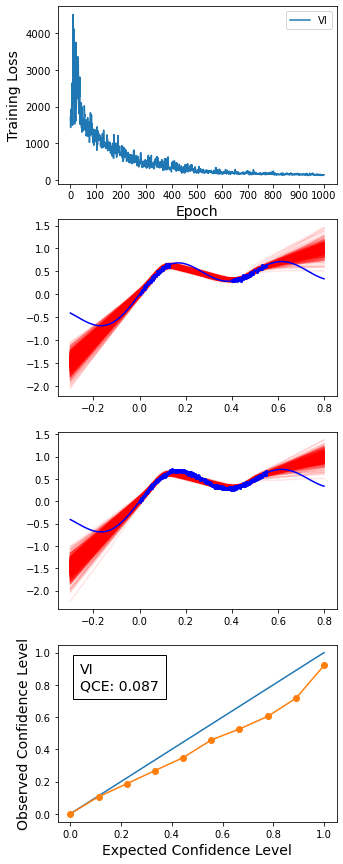

In [30]:
plot_grid(dataset, testset, [("VI", model, 1000)], device)

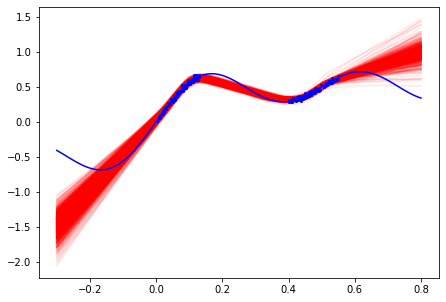

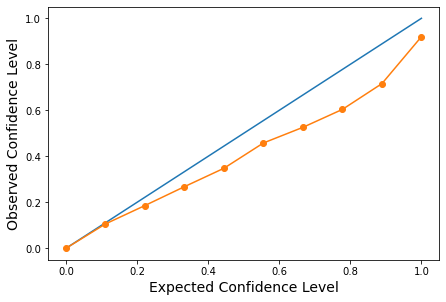

In [32]:
from experiments.toy_regression import store_results

store_results(dataset, testset, [("full_vi", model, 1000)], device)

In [31]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).shape)

guide.loc torch.Size([1153])
guide.scale torch.Size([1153])
guide.scale_tril torch.Size([1153, 1153])
